In [1]:
from scipy import sparse
from bluepysnap import Circuit
from graph_analysis.randomize import WeightPermutedRandomModel
from graph_analysis.rich_cub import RichClubAnalysis
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
file_format = 'png'
dpi = 300

In [3]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
synaptome = sparse.load_npz(adj_path)
connectome = synaptome.copy()
connectome[connectome > 0] = 1
# del synaptome

target = 'slice10'
CIRCUIT_DIR =  '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(CIRCUIT_DIR)
nodes = circuit.nodes["hippocampus_neurons"]
edges = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]
target_indices = nodes.ids(target)
target_synaptome = synaptome[target_indices,:][:,target_indices]
target_connectome = connectome[target_indices,:][:,target_indices]

In [81]:
del target_synaptome, target_connectome

In [4]:
# model_dp = WeightPermutedRandomModel(target_synaptome)

# random_adjs = []

# for i in tqdm(range(100)):
#     dp_adj = model_dp.generate(seed=i)
#     random_adjs.append(dp_adj)

In [4]:
# calculate the rich club coefficients for the original graph
rca_syn = RichClubAnalysis(target_synaptome)
client = Client()    # Start Dask client
k_dict_parallel_model = rca_syn.calculate_rich_club_coefficients(weighted=True,
                            method='strongest-links-in-network',step=100)
client.shutdown()    # Shutdown the Dask client

INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:38982. Reason: nanny-close
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:34367. Reason: nanny-close
INFO:distributed.core:Connection to tcp://127.0.0.1:34143 has been closed.
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:40809. Reason: nanny-close
INFO:distributed.core:Connection to tcp://127.0.0.1:34143 has been closed.
INFO:distributed.core:Connection to tcp://127.0.0.1:34143 has been closed.
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:38238. Reason: nanny-close
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:40658. Reason: nanny-close
INFO:distributed.core:Connection to tcp://127.0.0.1:34143 has been closed.
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:39066. Reason: nanny-close
INFO:distributed.core:Connection to tcp://127.0.0.1:34143 has been closed.
INFO:distributed.core:Connection to tcp://127.0.0.1:34143 has been closed.


In [21]:
original_coeffs = pd.DataFrame.from_dict(k_dict_parallel_model, orient='index').T
# original_coeffs.to_csv(f'../output/rich_club/weigted_rcc_{target}.csv')

In [7]:
original_coeffs = pd.read_csv('../output/rich_club/weigted_rcc_slice10.csv',index_col=0)

In [4]:
output_dir = '../output/rich_club/'
random_rc_coeffs = pd.read_csv(f'{output_dir}/random_rc_coeffs.csv',index_col=0)
average_random_coeffs = np.mean(random_rc_coeffs, axis=0).to_frame().T

In [8]:
normalized_coeffs = original_coeffs.values[:,:average_random_coeffs.shape[1]] / average_random_coeffs.values

In [9]:
normalized_rc_df = pd.DataFrame(normalized_coeffs,columns=average_random_coeffs.columns).T

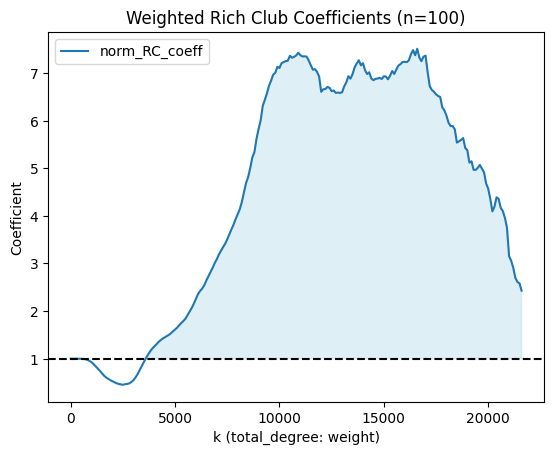

In [10]:
f ,ax= plt.subplots()
x= np.array(normalized_rc_df.index).astype(float).astype(int)
ax.plot(x, normalized_rc_df.values.flatten(), label='Data')
ax.fill_between(x, normalized_rc_df.values.flatten(), y2=1, where=(normalized_rc_df.values.flatten() >= 1), color='lightblue', alpha=0.4)
ax.axhline(y=1, color='k', linestyle='--', label='y=1')

plt.title('Weighted Rich Club Coefficients (n=100)')
plt.xlabel('k (total_degree: weight)')
plt.ylabel('Coefficient')
plt.legend(['norm_RC_coeff'])
plt.savefig(f"../output/rich_club_weigted_{target}.png", dpi=dpi, bbox_inches='tight')

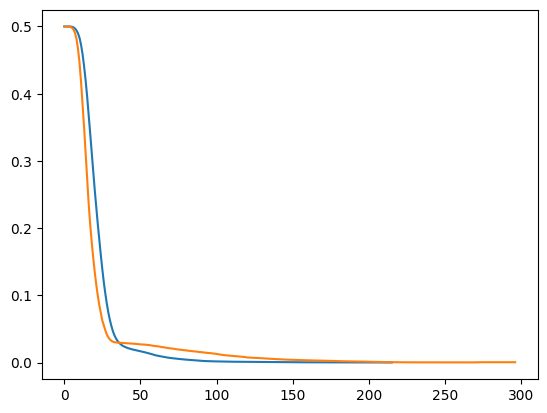

In [11]:
plt.plot(random_rc_coeffs.values.mean(axis=0).flatten())
plt.plot(original_coeffs.values.flatten())

In [22]:
# generate er and dd as well

from graph_analysis.randomize import DistanceDependentConfigurationalModel, ErdosRenyiModel
from graph_analysis.rich_club import RichClubAnalysis

In [15]:
xyz = nodes.get(target)[['x','y','z']]

er_generator = ErdosRenyiModel(target_synaptome)
# model = BarabasiAlbertModel(adj)
# model = WattsStrogatzModel(adj)
# model = ConfigurationModel(adj)
# model = DistanceDependentConfigurationalModel(target_synaptome,xyz)

dd_generator = DistanceDependentConfigurationalModel(target_synaptome,xyz)

In [20]:
er1 = er_generator.generate() *= num_syns_per_conn
dd_model = dd_generator.generate().astype(int)
dd_weights = np.random.random(dd_model.data.shape[0]) * num_syns_per_conn
dd_model.data = dd_weights

12615it [00:05, 2167.43it/s]


In [35]:
inh_indices = np.where(nodes.get(target).morph_class=='INT')[0]
exc_indices = np.where(nodes.get(target).morph_class=='PYR')[0]

In [27]:
num_syns_per_conn = target_synaptome.sum() / target_synaptome.count_nonzero()
num_syns_per_conn = np.round(num_syns_per_conn).astype(int)

In [45]:
ee_spc = target_synaptome[exc_indices,:][:,exc_indices].sum() / target_synaptome[exc_indices,:][:,exc_indices].count_nonzero()
ei_spc = target_synaptome[exc_indices,:][:,inh_indices].sum() / target_synaptome[exc_indices,:][:,inh_indices].count_nonzero()
ie_spc = target_synaptome[inh_indices,:][:,exc_indices].sum() / target_synaptome[inh_indices,:][:,exc_indices].count_nonzero()
ii_spc = target_synaptome[inh_indices,:][:,inh_indices].sum() / target_synaptome[inh_indices,:][:,inh_indices].count_nonzero()

In [47]:
print(f'EE:{ee_spc},\nEI:{ei_spc},\nIE:{ie_spc},\nII:{ii_spc}')

EE:1.3327996206466048,
EI:6.355439853452315,
IE:11.538668999442502,
II:5.425033354635453


In [49]:
def density(arr):
    if arr.shape[0] == arr.shape[1]:
        return arr.count_nonzero() / (arr.shape[0]*(arr.shape[1]-1))
    else:
        return arr.count_nonzero() / (arr.shape[0]*(arr.shape[1]))
    
ee_dens =  density(target_synaptome[exc_indices,:][:,exc_indices])
ei_dens =  density(target_synaptome[exc_indices,:][:,inh_indices])
ie_dens = density(target_synaptome[inh_indices,:][:,exc_indices])
ii_dens =  density(target_synaptome[inh_indices,:][:,inh_indices])

In [56]:
er_ee = sparse.random(len(exc_indices), len(exc_indices), density=ee_dens, format='csr') * ee_density
er_ei = sparse.random(len(exc_indices), len(inh_indices), density=ei_dens, format='csr') * ei_density
er_ie = sparse.random(len(inh_indices), len(exc_indices), density=ie_dens, format='csr') * ie_density
er_ii = sparse.random(len(inh_indices), len(inh_indices), density=ii_dens, format='csr') * ii_density

In [65]:
sbm = sparse.vstack([sparse.hstack([er_ee,er_ei]),sparse.hstack([er_ie,er_ii])])

In [83]:
rca_dd = RichClubAnalysis(dd_model)
rca_er = RichClubAnalysis(er1)
# rca_sbm = RichClubAnalysis(sbm)

client = Client()    # Start Dask client
k_dict_parallel_dd = rca_dd.calculate_rich_club_coefficients(weighted=True,
                                                            method='strongest-links-in-network',
                                                            scheduler=None,
                                                            step=100)
k_dict_parallel_er = rca_er.calculate_rich_club_coefficients(weighted=True,
                                                            method='strongest-links-in-network',
                                                            scheduler=None,
                                                            step=100)
# k_dict_parallel_sbm = rca_sbm.calculate_rich_club_coefficients(weighted=True,
#                                                             method='strongest-links-in-network',
#                                                             scheduler=None,
#                                                             step=100)
client.shutdown()    # Shutdown the Dask client

2023-07-11 14:07:26,871 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/distributed/protocol/core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/msgpack/__init__.py", line 38, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "ms

CancelledError: wrapper-5b8bcb8e-87ca-4cb2-9c5d-07edbf78be1d

In [ ]:
f ,ax= plt.subplots(figsize=(10,10))

plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())
plt.plot(k_dict_parallel_er.keys(),k_dict_parallel_er.values())
# plt.plot(k_dict_parallel_dp.keys(),k_dict_parallel_dp.values())

norm_rc = np.array(list(k_dict_parallel_model.values())) / np.array(list(k_dict_parallel_dp.values()))
plt.plot(k_dict_parallel_model.keys(),norm_rc)
ax.axhline(y=1, color='k', linestyle='--', label='y=1')
ax.fill_between(k_dict_parallel_model.keys(), norm_rc, 1, where=(np.array(norm_rc) >= 1), color='lightgray')

plt.title('Rich Club Coefficients for slice10 connectome (total-degree)')
plt.xlabel('k (connections)')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice',
            'distance-dependent random model',
            'ER Model',
            'degree-preserving model (dp)',
            'norm_RC_coeff (CA1/dp)'])
# plt.savefig(f"../output/rich_club_directed_totdegree.png", dpi=dpi, bbox_inches='tight')

# Statistical Tests

I didnt see a 

In [168]:
u_stat, p_val = stats.mannwhitneyu(random_rc_coeffs.values, 
                                   original_coeffs.values[:,:random_rc_coeffs.shape[1]], alternative='two-sided')


print(f"U statistic: {u_stat}")
print(f"P-value: {p_val}")

# interpret the result
alpha = 0.05  # significance level
if p_val < alpha:
    print("The rich-club coefficient of the original graph is significantly different from the coefficients of the randomized graphs.")
else:
    print("There is not enough evidence to suggest that the rich-club coefficient of the original graph is significantly different from the coefficients of the randomized graphs.")


U statistic: [ 50.  40.  45. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.   5.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [171]:
np.where(p_val < alpha)

(array([], dtype=int64),)

In [148]:
from scipy import stats

# aligned_arr1 = np.repeat(original_coeffs.values[:,:random_rc_coeffs.shape[1]], random_rc_coeffs.shape[0], axis=0)
control_data_mean = np.nanmean(random_rc_coeffs.values, axis=0).reshape(1,217)

t_statistic, p_value = stats.ttest_1samp(original_coeffs.values[:,:random_rc_coeffs.shape[1]], 
                                         control_data_mean,
                                         nan_policy='omit'
                                         )

print('Statistical Test Results:')
print('T-Statistic:', t_statistic)
print('P-Value:', p_value)

Statistical Test Results:
T-Statistic: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
P-Value: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/scipy/stats/_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


<!-- # Use Dask to distribute among slurm nodes -->

In [77]:
# from dask_jobqueue import SLURMCluster
# import os

# def calculate_rich_club_coefficients(target_synaptome, seed):
#     model_dp = WeightPermutedRandomModel(target_synaptome)
#     dp_adj = model_dp.generate(seed=seed)

#     rca_dp = RichClubAnalysis(dp_adj)
#     k_dict_parallel_dp = rca_dp.calculate_rich_club_coefficients(weighted=True,
#                             method='strongest-links-in-network',step=100)
#     return k_dict_parallel_dp.values()

# n_trials = 5

# # setup SLURM cluster
# random_type = 'WP'
# cluster = SLURMCluster(queue='prod', 
#                        cores=4,
#                        name=f'rich_club_{random_type}',
#                        log_directory = f'{os.getcwd()}/slurm_logs/',
#                        memory="32GB", 
#                        walltime='01:00:00',
#                        account='proj112',
# #                       job_script="/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/toolbox/graph_analysis/notebooks/dask_worker.sbatch",
#                       )

# client = Client(cluster)

# # adjust the scale to match the number of trials (this might vary depending on your setup)
# cluster.scale(n_trials)  
# futures = client.map(calculate_rich_club_coefficients, [target_synaptome]*n_trials, range(n_trials))
# results = client.gather(futures)